<a href="https://colab.research.google.com/github/Akiyoshi-Yagi/GANs/blob/master/SimpleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
#入力次元の設定
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

#生成器への入力ノイズの次元
z_dim = 100

In [0]:
#生成器
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [0]:
#識別器
def build_discriminator(image_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
#コンパイル！

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

#識別器の構築及びコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=["accuracy"])

#生成器の構築
generator = build_generator(img_shape, z_dim)
#生成器の構築中は、識別器のパラメータは固定する
discriminator.trainable = False
#GANモデルの構築及びコンパイル
gan = build_gan(generator, discriminator)
gan.compile(loss="binary_crossentropy",optimizer=Adam())

In [20]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train.shape)

(60000, 28, 28)


In [0]:
#訓練！
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  (X_train, Y_train), (X_test, Y_test) = mnist.load_data() #X_train.shape=(60000, 28, 28)
  X_train = X_train /127.5 - 1.0
  X_train  = np.expand_dims(X_train, axis=3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):

    #本物の画像からランダムに取り出したバッチを作る
    idx = np.random.randint(0, X_train.shape[0],batch_size)
    imgs = X_train[idx]
    #偽の画像のバッチを作成する
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    #識別器の訓練
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    #偽の画像のバッチを作成
    z = np.random.normal(0, 1, (batch_size, 100))
    ge_images = generator.predict(z)
    #生成器の訓練
    g_loss = gan.train_on_batch(z, real)

    if (iteration+1) % sample_interval == 0:

      #イテレーションお気に損失値と整合値を記録
      losses.append((d_loss, g_loss))
      accuracies.append(100 * accuracy)
      iteration_checkpoints.append(iteration+1)

      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
      sample_images(generator)

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    #ランダムノイズのサンプリング
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)

    #画素値のスケール
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.129656, acc.: 96.09%] [G loss: 3.387729]
2000 [D loss: 0.079047, acc.: 97.66%] [G loss: 3.964481]
3000 [D loss: 0.071152, acc.: 97.27%] [G loss: 5.072118]
4000 [D loss: 0.217956, acc.: 91.02%] [G loss: 3.993687]
5000 [D loss: 0.380112, acc.: 86.72%] [G loss: 3.941338]
6000 [D loss: 0.292950, acc.: 89.45%] [G loss: 4.491636]
7000 [D loss: 0.345073, acc.: 85.55%] [G loss: 4.056399]
8000 [D loss: 0.396545, acc.: 86.33%] [G loss: 3.101150]
9000 [D loss: 0.744731, acc.: 70.70%] [G loss: 2.761991]
10000 [D loss: 0.444913, acc.: 80.86%] [G loss: 3.474383]
11000 [D loss: 0.362310, acc.: 82.81%] [G loss: 3.101751]
12000 [D loss: 0.383188, acc.: 84.38%] [G loss: 3.111648]
13000 [D loss: 0.283140, acc.: 89.06%] [G loss: 3.082010]
14000 [D loss: 0.411019, acc.: 81.64%] [G loss: 2.747284]
15000 [D loss: 0.386751, acc.: 82.03%] [G loss: 2.795580]
16000 [D loss: 0.475734, acc.: 80.86%] [G loss: 2.436490]
17000 [D loss: 0.285364, acc.: 89.45%] [G loss: 2.764011]
18000 [D loss: 0.202013

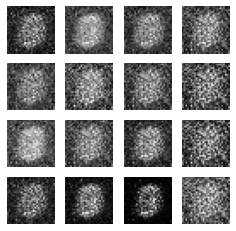

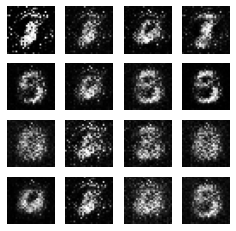

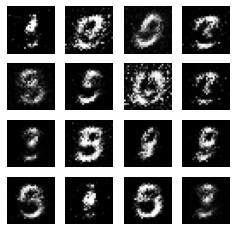

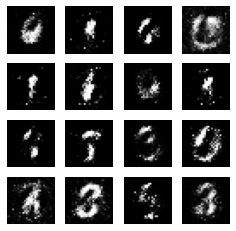

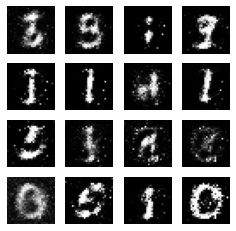

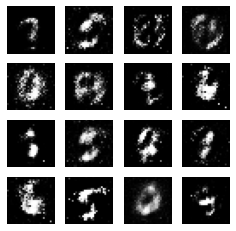

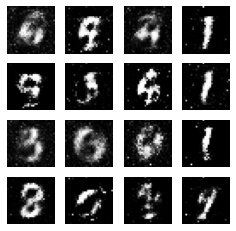

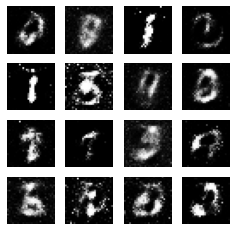

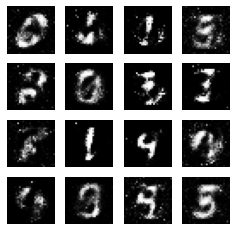

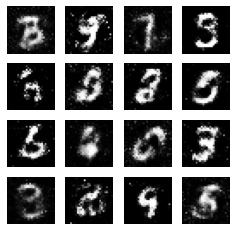

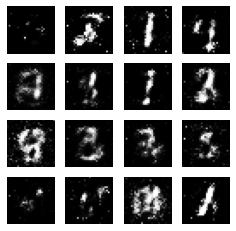

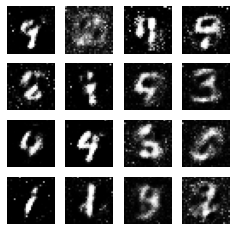

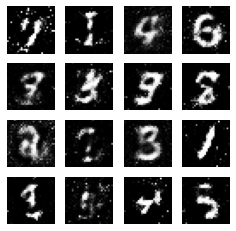

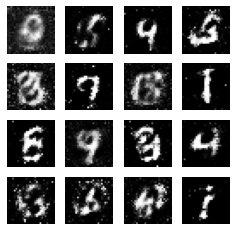

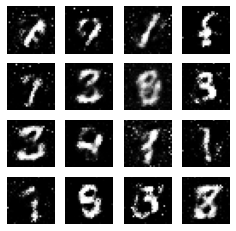

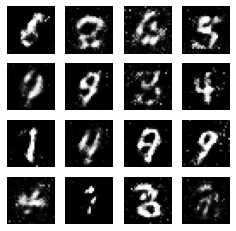

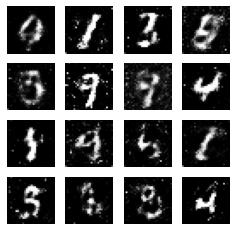

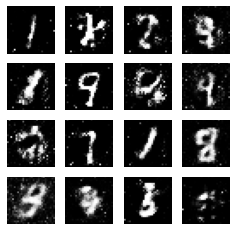

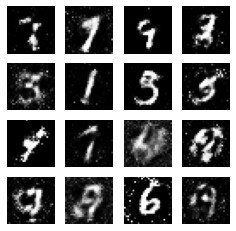

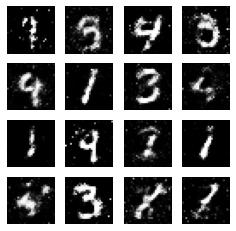

In [26]:
iterations = 20000
batch_size = 128
sample_interval = 1000
train(iterations, batch_size, sample_interval)